# Demo: PeakFinder

This is a demonstration of a peak finding algorithm whose API is loosly based on Matlab's [findpeaks](https://de.mathworks.com/help/signal/ref/findpeaks.html?requestedDomain=www.mathworks.com) function.

You can find the source code of the class `PeakFinder` [here](https://gitlab.com/lagru/peakfinder-demo/blob/master/peak_finder.py).

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(".")
from peak_finder import PeakFinder

First let's create a test signal whose peaks have different properties to allow meaningful filtering.

In [2]:
# Make test signal
pos = np.array([1, 2, 3, 5, 7, 8]) / 10
height = np.array([4, 4, 2, 2, 2, 3])
width = np.array([3, 8, 4, 3, 4, 6]) / 100

t = np.linspace(0, 1, 1000)
vec = np.zeros(t.shape)
for i in range(pos.size):
    vec += height[i] * np.exp(-((t - pos[i]) / width[i]) ** 2)
    
vec[350:358] += np.array([2, 4, 6, 10, 7, 5, 3, 1]) / 10
vec = np.r_[vec, vec[::-1]]
vec -= 2 * np.sin(np.linspace(0, 3.5*np.pi, vec.size))
vec[900:950] = 2.5

Initialize the peak finder but don't specify filters yet. We can display the found peaks conveniently with `PeakFinder`'s `plot` method.

<IPython.core.display.Javascript object>


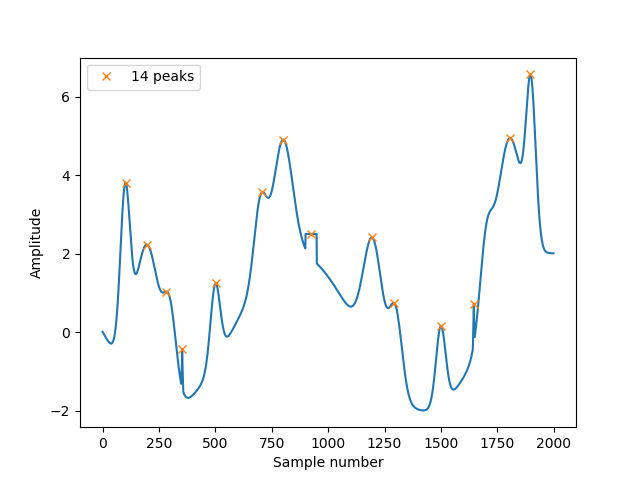

In [3]:
peak_finder = PeakFinder(vec)
peak_finder.plot();

Now, let's filter the peaks by their height. We want to detect peaks with heights in the interval `[1.2, 4]`.

<IPython.core.display.Javascript object>


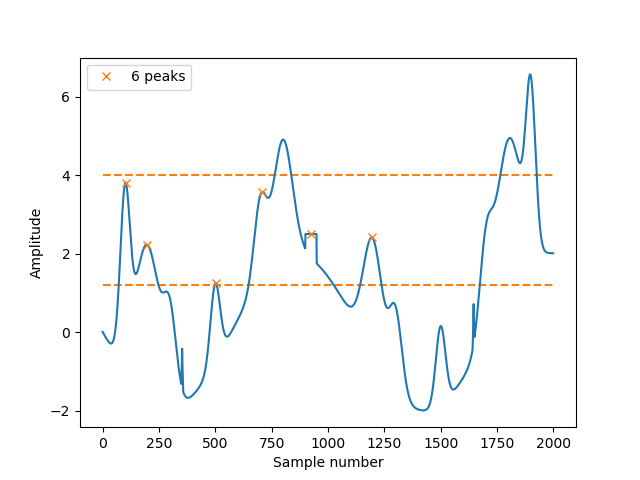

In [4]:
hmin, hmax = 1.2, 4
peak_finder.filter_by_height(hmin, hmax)
ax = peak_finder.plot()
ax.hlines(y=(hmin, hmax), xmin=0, xmax=peak_finder.vec.size, colors="C1", linestyles="dashed");

Peaks can be filtered by their threshold as well. The threshold is defined as the height difference between a peak and its adjacent samples. In this case we demand a minimal threshold of `0.1`. Only the very sharp peak at `253` fullfills this requirement.

**Note:** We can undo previous filters by calling the method `reset`.

<IPython.core.display.Javascript object>


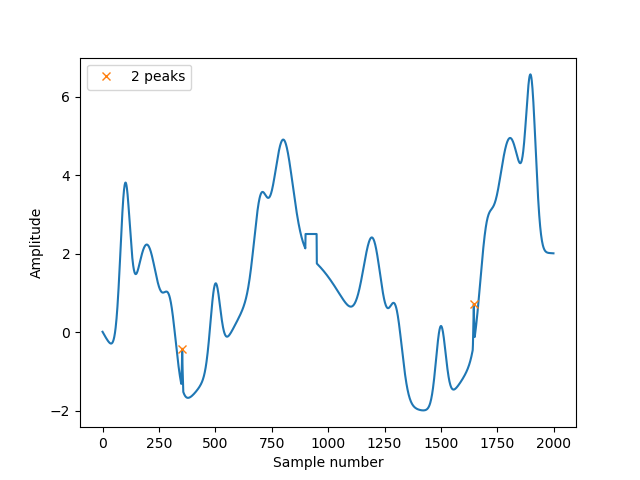

In [5]:
peak_finder.reset()
peak_finder.filter_by_threshold(tmin=0.1)
peak_finder.plot();

Let's filter our peaks by their distance to each other. In this example we want a minimal distance of 200 samples between each peaks. If two peaks are closer than this distance the smaller one is removed.

<IPython.core.display.Javascript object>


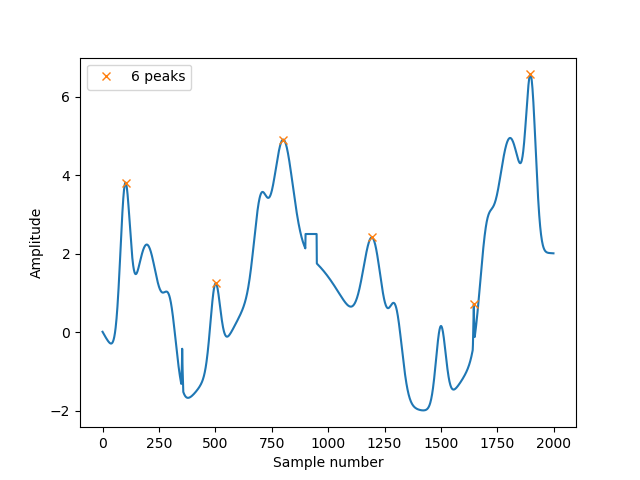

In [6]:
peak_finder.reset()
peak_finder.filter_by_distance(dmin=200)
peak_finder.plot();

Peak finder allows us to explore and filter by the peaks shape. The shape of a peak is defined by its [prominence](https://en.wikipedia.org/wiki/Topographic_prominence) (a measure how a peak stands out from the rest of a signal) and its width at a certain height (relative to its prominence).

First lets calculate the prominences of each peak and examine the results:

Peak prominences:
[ 0.02663376  0.13555379  0.15137819  0.36628733  0.64363409  0.75432483
  0.83873443  0.89541559  1.36092471  1.62066942  1.76407693  4.10347267
  4.5607709   6.58366422]


<IPython.core.display.Javascript object>


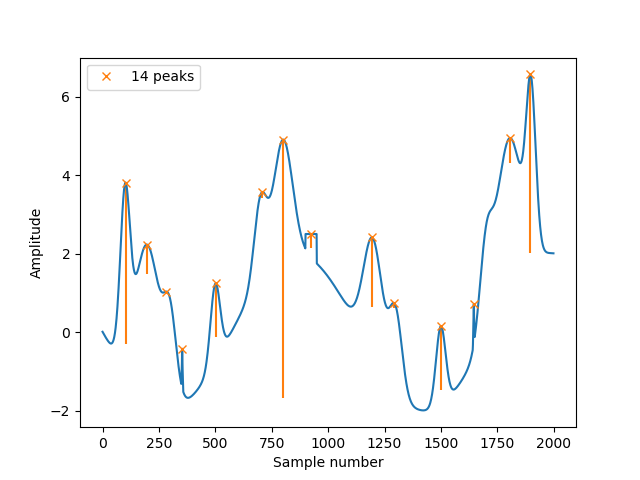

In [7]:
peak_finder.reset()
print("Peak prominences:\n", np.sort(peak_finder.prominences()), sep="")
peak_finder.plot();

As we can see the prominence is the vertical distance of a peak to its lowest [contour line](https://en.wikipedia.org/wiki/Contour_line). By looking at the resulting heights we may choose to only select peaks with a prominence greater than 2.

<IPython.core.display.Javascript object>


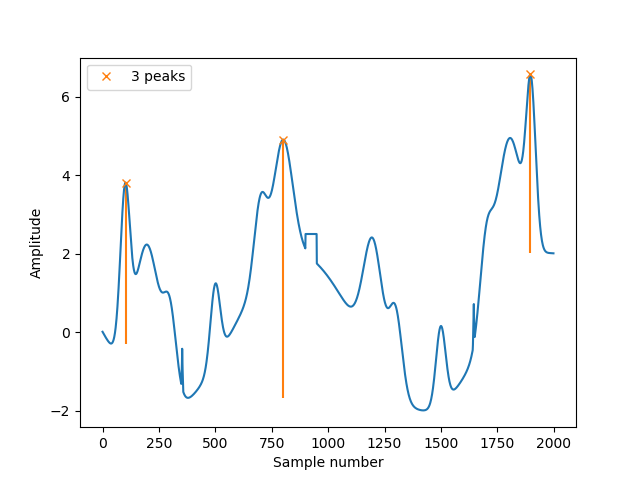

In [8]:
peak_finder.reset()
peak_finder.filter_by_prominence(pmin=2)
peak_finder.plot();

This feature is especially useful if we have a noisy signal with many small peaks:

<IPython.core.display.Javascript object>


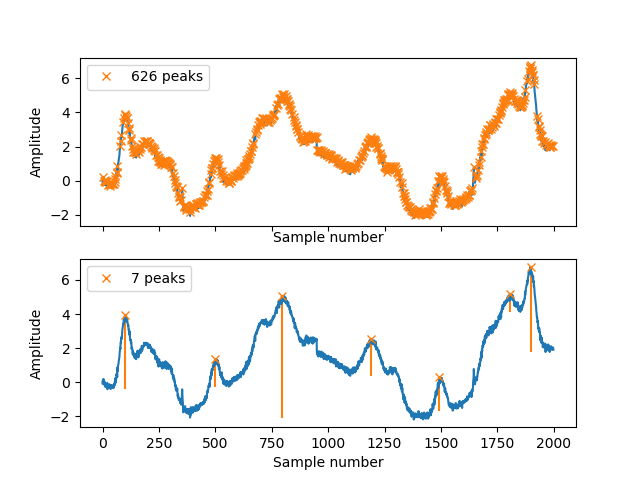

In [9]:
# Overlay signal with gaussian noise
peak_finder_with_noise = PeakFinder(vec + np.random.normal(0, 0.1, vec.size))

# Plot unfiltered signal
fig, ax = plt.subplots(2, 1, sharex=True)
peak_finder_with_noise.plot(ax=ax[0])

# Filter by prominence and plot figure
peak_finder_with_noise.filter_by_prominence(pmin=1)
peak_finder_with_noise.plot(ax=ax[1]);

The second property of the peak shape is its width, the horizontal distance between to points on the peak slopes at a certain height. `PeakFinder.width()` can calculate the width at two heights:

* `"halfprom"` - the width is calculated at half the peaks prominence.
* and `"fullprom"` - the with is calculated at the peaks base / the lowest contour line

First lets examine the width at half the prominence height:

Peak width at 'halfprom':
[   4.    4.   13.   22.   22.   40.   45.   49.   51.   55.   59.   77.
  152.  315.]


<IPython.core.display.Javascript object>


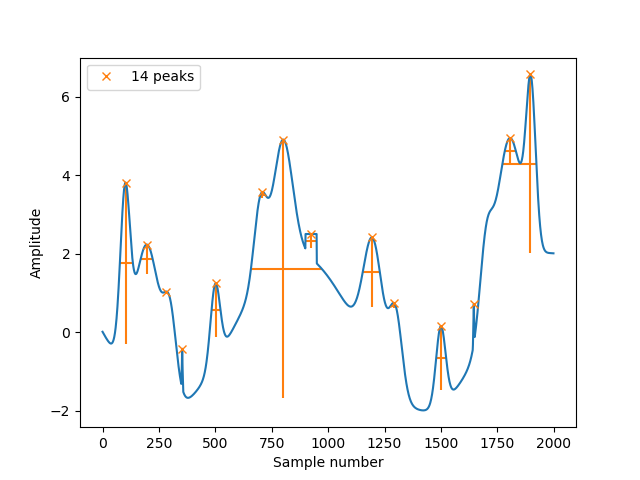

In [10]:
peak_finder.reset()

# Calculate widths at halfprom
widths, wheights, left, right = peak_finder.widths(wheight="halfprom")

# Print and plot widths
print("Peak width at 'halfprom':\n", np.sort(widths), sep="")
ax = peak_finder.plot()
ax.hlines(y=wheights, xmin=left, xmax=right, colors="C1");

We can restrict the desired peak width easily with `PeakFinder.filter_by_width(wmin, wmax, wheight="halfprom")`.

Peak width at 'halfprom':
[ 13.  22.  22.  40.  45.  49.  51.  55.  59.  77.]


<IPython.core.display.Javascript object>


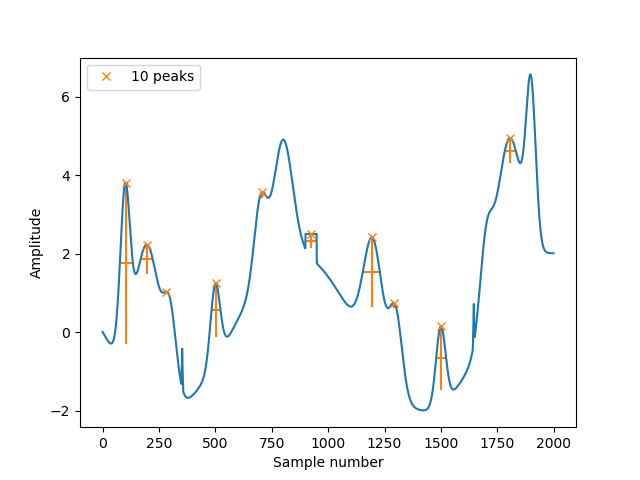

In [11]:
peak_finder.reset()
peak_finder.filter_by_width(wmin=10, wmax=80, wheight="halfprom")

# Print and plot resulting widths
widths, wheights, left, right = peak_finder.widths(wheight="halfprom")
print("Peak width at 'halfprom':\n", np.sort(widths), sep="")
ax = peak_finder.plot()
ax.hlines(y=wheights, xmin=left, xmax=right, colors="C1");

We can do the same with the option `"fullprom"`:

Peak width at 'fullprom':
[   8.    8.   22.   37.   39.   51.   79.   90.   92.  288.  314.  634.
  850.  983.]


<IPython.core.display.Javascript object>


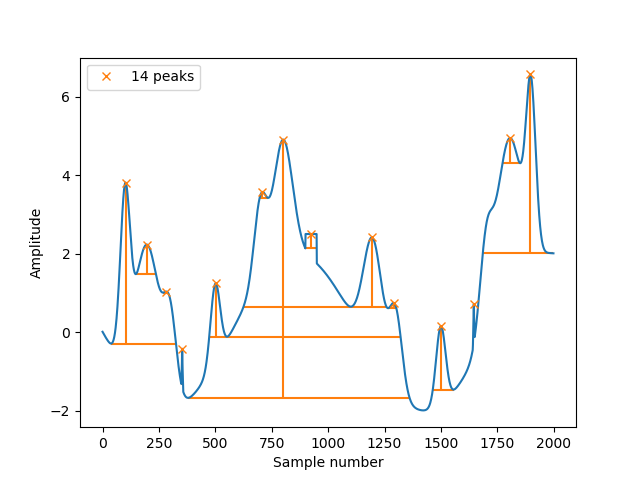

In [12]:
peak_finder.reset()
widths, wheights, left, right = peak_finder.widths(wheight="fullprom")

# Print and plot widths
print("Peak width at 'fullprom':\n", np.sort(widths), sep="")
ax = peak_finder.plot()
ax.hlines(y=wheights, xmin=left, xmax=right, colors="C1");